# Table of Contents

- [Load the dataset](#load-the-dataset)
- [Data Preparation](#data-preparation)
  - [Splitting the dataset with selected features](#splitting-the-dataset-with-selected-features)
  - [Scaling](#scaling)
  - [One-Hot Encoding (Target)](#one-hot-encoding-target)
- [Model](#model)
  - [Train the Model](#train-the-model)
  - [Plot Overfitting](#plot-overfitting)
  - [Plot Evaluation](#plot-evaluation)
  - [Baseline Models for Comparison](#baseline-models-for-comparison)
    - [Logistic Regression](#logistic-regression)
    - [Support Vector Machine](#support-vector-machine)
  - [Compare Model with Baseline-Models](#compare-model-with-baseline-models)
- [Oversampling with SMOTE](#oversampling-with-smote)
  - [New Model With SMOTE-Data](#new-model-with-smote-data)
  - [Compare "SMOTE-Model" with Baseline Models](#compare-smote-model-with-baseline-models)


# Load the dataset

In [ ]:
%pip install ucimlrepo

# Load the dataset

from ucimlrepo import fetch_ucirepo

# Data Preperation

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml  # Use fetch_openml to get the dataset
# Load the dataset
df = fetch_ucirepo(id=193)

# Extract data as pandas DataFrames
X = df.data.features
y = df.data.targets

# Drop the first column of the target variable
y = y.iloc[:, 1]  # Selecting the NSP column (Normal, suspect, pathologic)


# Feature selection with SelectKBest
bestfeatures = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
fit = bestfeatures.fit(X, y)  # Fit on the data

# Combine scores and feature names for reference
dfscores = pd.DataFrame(fit.scores_, columns=['Score'])
dfcolumns = pd.DataFrame(X.columns, columns=['Specs'])
featureScores = pd.concat([dfcolumns, dfscores], axis=1)

# Select the top 10 features
top_features = featureScores.nlargest(10, 'Score')['Specs']
X_selected = X[top_features]

# Drop 'Mode' and 'Median' columns due to high correlation with 'Mean'
X_selected = X_selected.drop(['Mode', 'Median'], axis=1)

print("Shape of X_selected:", X_selected.shape)
print("Selected features:", list(X_selected.columns))
print("Shape of y:", y.shape)
print(y.head())  # Zeigt die ersten Zeilen von y
print("Number of samples in X_selected:", X_selected.shape[0])
print("Number of samples in y:", y.shape[0])

Shape of X_selected: (2126, 8)
Selected features: ['DP', 'ALTV', 'ASTV', 'Mean', 'AC', 'Variance', 'LB', 'MSTV']
Shape of y: (2126,)
0    2
1    1
2    1
3    1
4    1
Name: NSP, dtype: int64
Number of samples in X_selected: 2126
Number of samples in y: 2126


## Splitting the dataset with selected features

In [ ]:
# Splitting the dataset with selected features
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# Cheking Shapes
print("Train X shape:", X_train_selected.shape)
print("Test X shape:", X_test_selected.shape)
print("Train y shape:", y_train.shape)
print("Test y shape:", y_test.shape)

from collections import Counter

Train X shape: (1700, 8)
Test X shape: (426, 8)
Train y shape: (1700,)
Test y shape: (426,)


## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled_selected= scaler.fit_transform(X_train_selected)
X_test_scaled_selected = scaler.transform(X_test_selected)


print("Scaled Train X shape:", X_train_scaled_selected.shape)
print("Scaled Test X shape:", X_test_scaled_selected.shape)

Scaled Train X shape: (1700, 8)
Scaled Test X shape: (426, 8)


## One-Hot Encoding (Target)

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert target variable to one-hot encoding (only for neural network)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Check the shapes of the datasets
print("Shape of y_train before one-hot encoding:", y_train.shape)
print("Shape of y_train after one-hot encoding:", y_train_categorical.shape)

print("Shape of y_test before one-hot encoding:", y_test.shape)
print("Shape of y_test after one-hot encoding:", y_test_categorical.shape)

Shape of y_train before one-hot encoding: (1700,)
Shape of y_train after one-hot encoding: (1700, 4)
Shape of y_test before one-hot encoding: (426,)
Shape of y_test after one-hot encoding: (426, 4)


# Model

## Previous Random Search

The chosen hyperparameters are based on a preceding random search. The codes for the random search are not part of the present notebook, but the following hyperparameters were varied as follows:

**Hyperparameters varied in the Random Search:**

- layer1: Number of neurons in the first layer (input layer). Range: 64 to 256
(in steps of 32).

- dropout_rate_1: Dropout rate for the first layer. Range: 0.1 to 0.5 (in steps of 0.1).

- num_hidden_layers Number of hidden layers Range: 1 to 5.

- layer_{i+2}: Number of neurons in each hidden layer. Range: 32 to 128 (in steps of 16).

- dropout_rate_{i+2} Dropout rate for each hidden layer (each layer has its own hyperparameter). Range: 0.1 to 0.5 (in steps of 0.1).

- learning_rate Learning rate for the Adam optimizer. Range: 1e-5 to 1e-3 (logarithmic sampling)

**Best Options**

Best number of neurons in Layer 1: 224

Best dropout rate in Layer 1: 0.2

Best number of hidden layers: 2

Best number of neurons in Layer 2: 112

Best dropout rate in Layer 2: 0.30000000000000004

Best number of neurons in Layer 3: 128

Best dropout rate in Layer 3: 0.1

Best learning rate: 0.000492210572872919


## Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_model(input_dim, optimizer=Adam,
                 dropout_rate_layer1=0.2, dropout_rate_layer2=0.3, dropout_rate_layer3=0.1,
                 learning_rate=0.000492210572872919, l2_reg=0.01):
    model = Sequential([
        Dense(224, input_dim=input_dim, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate_layer1),

        Dense(112, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate_layer2),

        Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate_layer3),

        Dense(y_train_categorical.shape[1], activation='softmax')
    ])

    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


input_dim = X_train_scaled_selected.shape[1]
model = create_model(input_dim=input_dim,
                     optimizer=Adam,
                     dropout_rate_layer1=0.2,
                     dropout_rate_layer2=0.3,
                     dropout_rate_layer3=0.1,
                     learning_rate=0.000492210572872919,
                     l2_reg=0.01)

# Print the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 224)                 │           2,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 224)                 │             896 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 112)                 │          25,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112)                 │             448 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          14,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,052 (172.08 KB)

 Trainable params: 43,124 (168.45 KB)

 Non-trainable params: 928 (3.62 KB)

## Train the Model

In [ ]:
import time

# Capture start time
start_time = time.time()

# Model training
history = model.fit(
    X_train_scaled_selected,
    y_train_categorical,
    validation_data=(X_test_scaled_selected, y_test_categorical),
    epochs=200,
    batch_size=32,
    verbose=1
)

# Capture end time
end_time = time.time()

# Calculate and print duration
training_duration = end_time - start_time
print(f"Training completed in {training_duration:.2f} seconds.")


## Plot Overfitting

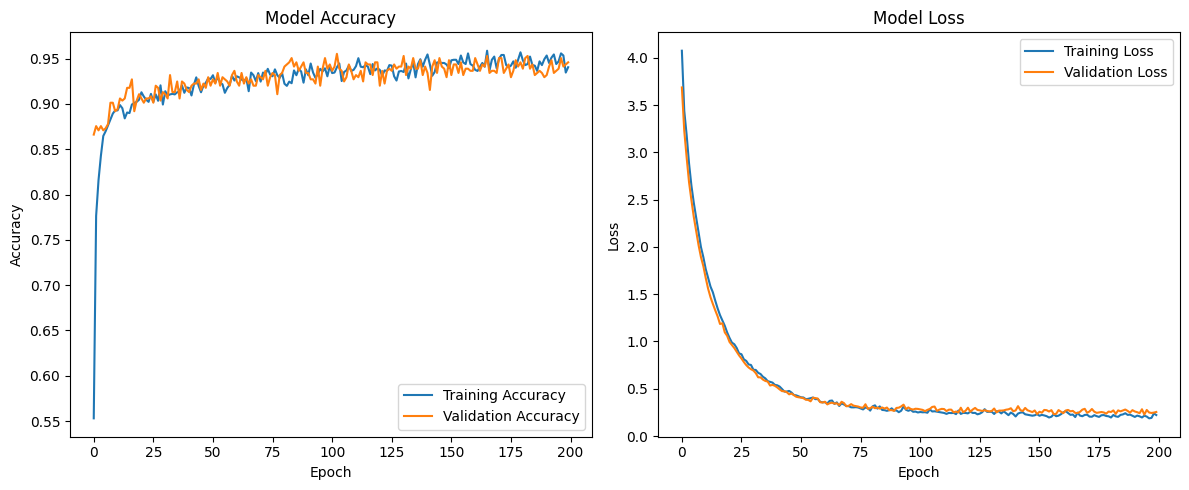

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss for your model
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Plot Evaluation

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

--- Neural Network (Selected Features) ---
Accuracy: 0.95

Classification Report:
              precision    recall  f1-score     support
Normal         0.978528  0.957958  0.968134  333.000000
Suspect        0.791667  0.890625  0.838235   64.000000
Pathologic     0.964286  0.931034  0.947368   29.000000
accuracy       0.946009  0.946009  0.946009    0.946009
macro avg      0.911493  0.926539  0.917912  426.000000
weighted avg   0.949485  0.946009  0.947205  426.000000


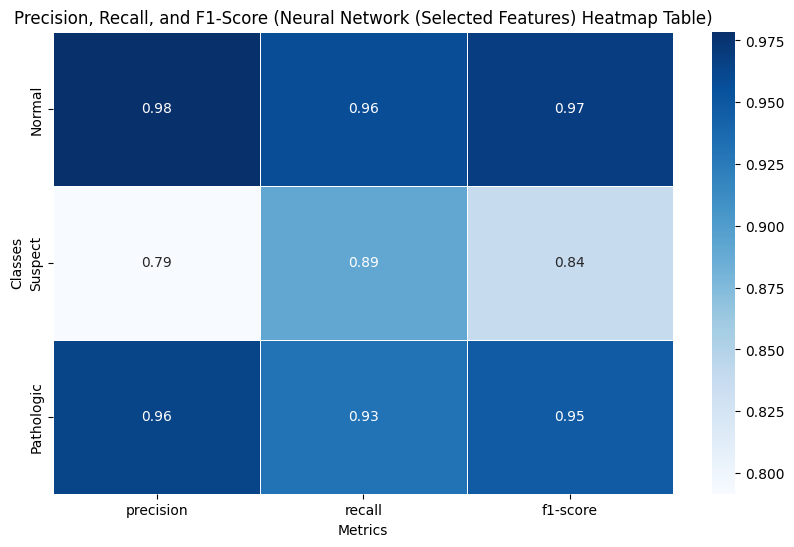

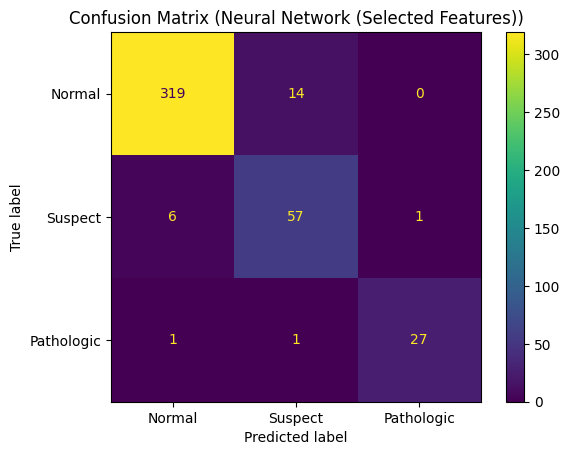

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

def evaluate_and_visualize_model_nn(model, X_test, y_test_categorical, model_name="Neural Network"):
    """
    Evaluates and visualizes the performance of a neural network model.

    Parameters:
    model: Trained neural network model
    X_test: Scaled test features
    y_test_categorical: One-hot encoded true labels for the test set
    model_name: Name of the model (e.g., "Neural Network")
    """
    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Class index with the highest probability
    y_test_classes = np.argmax(y_test_categorical, axis=1)  # Convert one-hot encoding back to labels

    # Calculate accuracy
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    print("\nClassification Report:")
    report = classification_report(y_test_classes, y_pred_classes,
                                    target_names=["Normal", "Suspect", "Pathologic"],
                                    output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)

    # Visualize the classification report as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report.iloc[:-3, :3], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
    plt.title(f"Precision, Recall, and F1-Score ({model_name} Heatmap Table)")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.show()

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=["Normal", "Suspect", "Pathologic"])
    disp.plot(cmap="viridis")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()


# Evaluate your trained model
evaluate_and_visualize_model_nn(
    model,  # Your trained model
    X_test_scaled_selected,  # Scaled test features used in training
    y_test_categorical,  # One-hot encoded test labels
    model_name="Neural Network (Selected Features)"
)


## Baseline Models for Comparison

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression

# Train Logistic Regression with class weights
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Automatically adjust class weights based on class frequencies
)

# Train the model on the scaled training data
lr_model.fit(X_train_scaled_selected, y_train)

print("Logistic Regression model has been successfully trained.")

Logistic Regression model has been successfully trained.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Support Vector Machine

In [ ]:
# Initialize and train an SVM with a non-linear kernel and class weights
from sklearn.svm import SVC

# Initialize SVM model with class weights
svm_model = SVC(
    kernel='rbf',  # Non-linear kernel
    probability=True,  # Enables probability estimation
    random_state=42,
    class_weight='balanced'  # Automatically adjusts weights for imbalanced classes
)

# Train the SVM model on the scaled training data
svm_model.fit(X_train_scaled_selected, y_train)

print("SVM model with non-linear kernel has been successfully trained.")

SVM model with non-linear kernel has been successfully trained.


## Compare Model with Baseline-Models

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


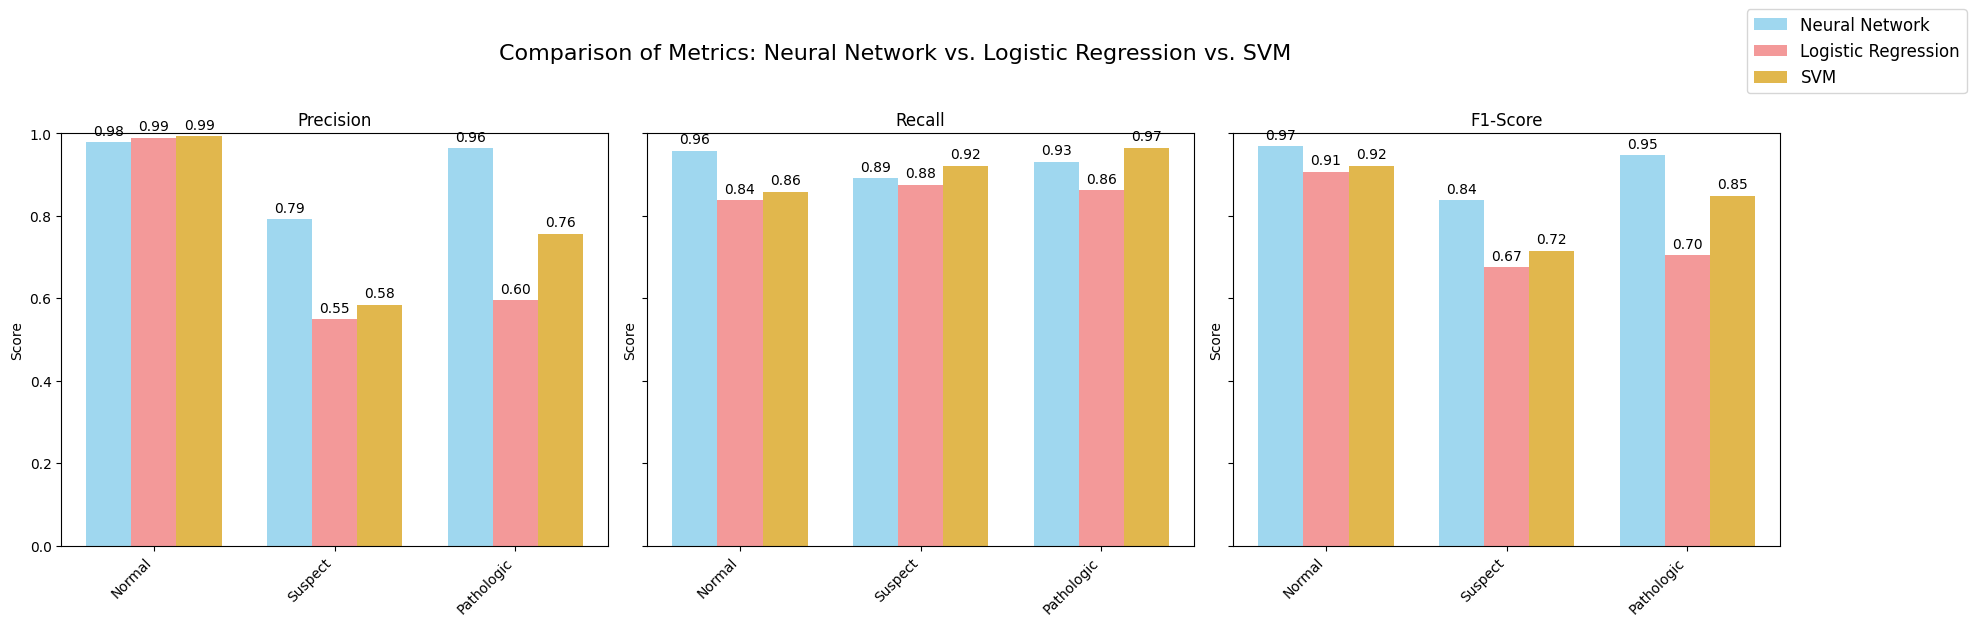


Model Comparison Summary:

Neural Network Weighted Average Metrics:
Precision: 0.949
Recall: 0.946
F1-Score: 0.947
Accuracy: 0.946

Logistic Regression Weighted Average Metrics:
Precision: 0.896
Recall: 0.845
F1-Score: 0.859
Accuracy: 0.845

SVM Weighted Average Metrics:
Precision: 0.916
Recall: 0.876
F1-Score: 0.885
Accuracy: 0.876


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

def compare_trained_models(model, lr_model, svm_model, X_test_scaled, y_test):
    """
    Compares a neural network model, a logistic regression model, and a support vector machine.
    Returns the comparison metrics and creates visualization plots, including Accuracy.
    """
    # Get predictions
    y_pred_nn = model.predict(X_test_scaled)
    y_pred_lr = lr_model.predict(X_test_scaled)
    y_pred_svm = svm_model.predict(X_test_scaled)

    # If the neural network outputs probabilities, convert them to class predictions
    if y_pred_nn.ndim > 1:
        y_pred_nn = np.argmax(y_pred_nn, axis=1)

    # Calculate Accuracy
    accuracy_nn = accuracy_score(y_test, y_pred_nn)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)

    # Get classification reports
    report_nn = classification_report(y_test, y_pred_nn,
                                      target_names=["Normal", "Suspect", "Pathologic"],
                                      output_dict=True)
    report_lr = classification_report(y_test, y_pred_lr,
                                       target_names=["Normal", "Suspect", "Pathologic"],
                                       output_dict=True)
    report_svm = classification_report(y_test, y_pred_svm,
                                        target_names=["Normal", "Suspect", "Pathologic"],
                                        output_dict=True)

    # Create comparison DataFrame with consistent naming
    comparison_data = {
        'precision_NN': [report_nn[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_NN': [report_nn[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_NN': [report_nn[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]],
        'precision_LogReg': [report_lr[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_LogReg': [report_lr[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_LogReg': [report_lr[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]],
        'precision_SVM': [report_svm[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_SVM': [report_svm[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_SVM': [report_svm[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]]
    }

    comparison_df = pd.DataFrame(comparison_data,
                                 index=["Normal", "Suspect", "Pathologic"])

    # Create visualization
    metrics = ["Precision", "Recall", "F1-Score"]
    classes = comparison_df.index
    x = np.arange(len(classes))
    width = 0.25

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, metric in enumerate(metrics):
        nn_values = comparison_df[f'{metric.lower()}_NN']
        lr_values = comparison_df[f'{metric.lower()}_LogReg']
        svm_values = comparison_df[f'{metric.lower()}_SVM']

        ax = axes[i]
        rects1 = ax.bar(x - width, nn_values, width, label='Neural Network', color='skyblue', alpha=0.8)
        rects2 = ax.bar(x, lr_values, width, label='Logistic Regression', color='lightcoral', alpha=0.8)
        rects3 = ax.bar(x + width, svm_values, width, label='SVM', color='goldenrod', alpha=0.8)  # Dark Yellow

        ax.set_title(metric)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)

        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width()/2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)
        autolabel(rects3)

    # Add a single legend for all plots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.05), fontsize=12)

    fig.suptitle("Comparison of Metrics: Neural Network vs. Logistic Regression vs. SVM", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print summary statistics
    print("\nModel Comparison Summary:")
    print("\nNeural Network Weighted Average Metrics:")
    print(f"Precision: {report_nn['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_nn['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_nn['weighted avg']['f1-score']:.3f}")
    print(f"Accuracy: {accuracy_nn:.3f}")

    print("\nLogistic Regression Weighted Average Metrics:")
    print(f"Precision: {report_lr['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_lr['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_lr['weighted avg']['f1-score']:.3f}")
    print(f"Accuracy: {accuracy_lr:.3f}")

    print("\nSVM Weighted Average Metrics:")
    print(f"Precision: {report_svm['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_svm['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_svm['weighted avg']['f1-score']:.3f}")
    print(f"Accuracy: {accuracy_svm:.3f}")

    return comparison_df


# Call the function with your models and test data
comparison_df = compare_trained_models(model, lr_model, svm_model, X_test_scaled_selected, y_test)


# Oversampling with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

from imblearn.over_sampling import SMOTE
from collections import Counter

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_selected, y_train)
# Check the new class distribution
print("Class distribution after SMOTE:", Counter(y_train_smote))
# Check the new shapes of the datasets
print("SMOTE Train X shape:", X_train_smote.shape)
print("SMOTE Train y shape:", y_train_smote.shape)



from tensorflow.keras.utils import to_categorical

y_train_smote_categorical = to_categorical(y_train_smote)  # One-Hot-Encoding

Class distribution after SMOTE: Counter({1: 1322, 2: 1322, 3: 1322})
SMOTE Train X shape: (3966, 8)
SMOTE Train y shape: (3966,)


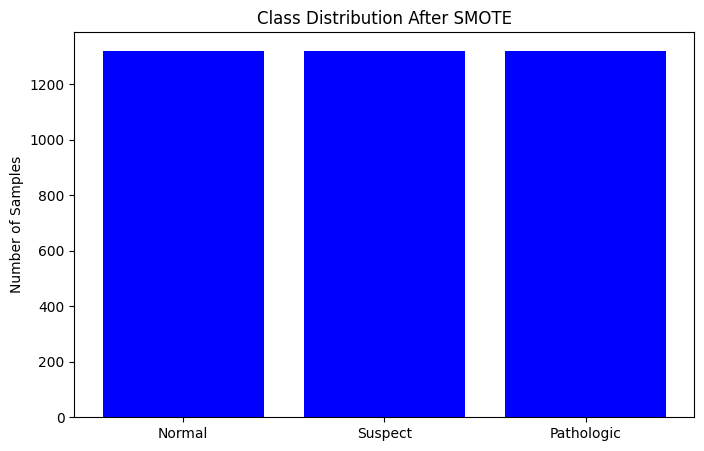

In [ ]:
# Class distribution after SMOTE
classes = [1, 2, 3]
counts = [1322, 1322, 1322]

# Plotting the class distribution with blue bars
plt.figure(figsize=(8, 5))
plt.bar(classes, counts, color='blue', tick_label=["Normal", "Suspect", "Pathologic"])
plt.title("Class Distribution After SMOTE")
plt.xlabel("")
plt.ylabel("Number of Samples")
plt.show()


## New Model With SMOTE-Data

In [ ]:
# Create a new model
input_dim = X_train_smote.shape[1]  # Number of input features
smote_model = create_model(input_dim=input_dim,
                           optimizer=Adam,
                           dropout_rate_layer1=0.2,
                           dropout_rate_layer2=0.3,
                           dropout_rate_layer3=0.1,
                           learning_rate=0.000492210572872919,
                           l2_reg=0.01)

# Capture start time
start_time = time.time()

# Train the model with SMOTE data
history = smote_model.fit(
    X_train_smote,
    y_train_smote_categorical,
    validation_data=(X_test_scaled_selected, y_test_categorical),
    epochs=200,
    batch_size=32,
    verbose=1
)

# Capture end time
end_time = time.time()

# Calculate and print duration
training_duration = end_time - start_time
print(f"Training completed in {training_duration:.2f} seconds.")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

--- Neural Network (SMOTE) ---
Accuracy: 0.93

Classification Report:
              precision    recall  f1-score     support
Normal         0.990446  0.933934  0.961360  333.000000
Suspect        0.737500  0.921875  0.819444   64.000000
Pathologic     0.875000  0.965517  0.918033   29.000000
accuracy       0.934272  0.934272  0.934272    0.934272
macro avg      0.867649  0.940442  0.899612  426.000000
weighted avg   0.944586  0.934272  0.937090  426.000000


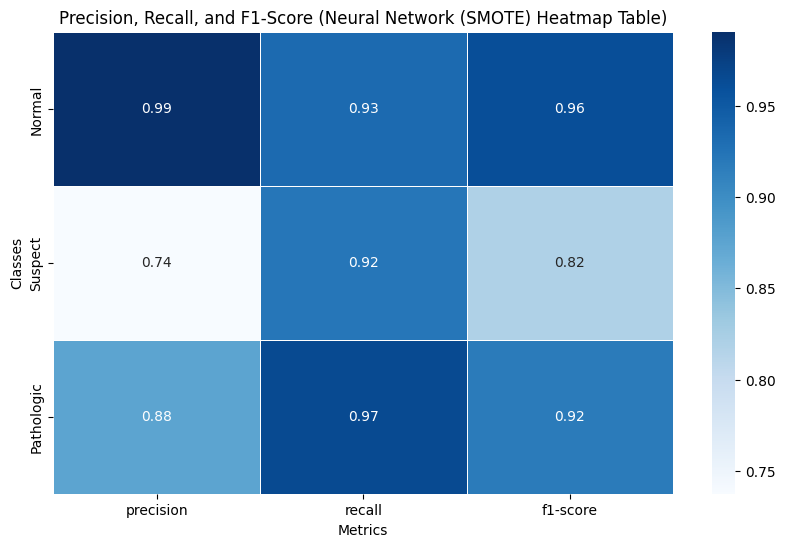

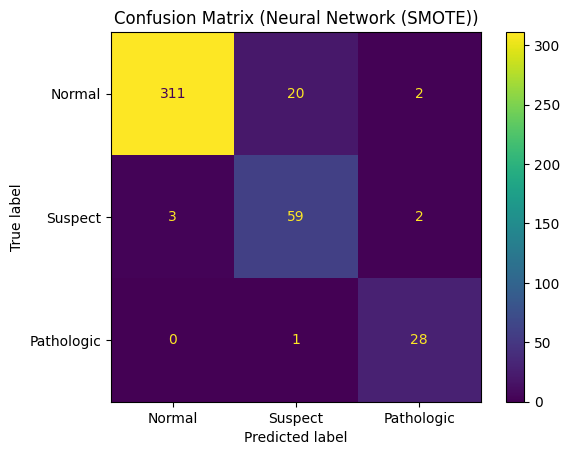

In [ ]:
# Evaluate SMOTE-trained model
evaluate_and_visualize_model_nn(
    smote_model,
    X_test_scaled_selected,
    y_test_categorical,
    model_name="Neural Network (SMOTE)"
)

## Compare "SMOTE-Model" with Baseline Models

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


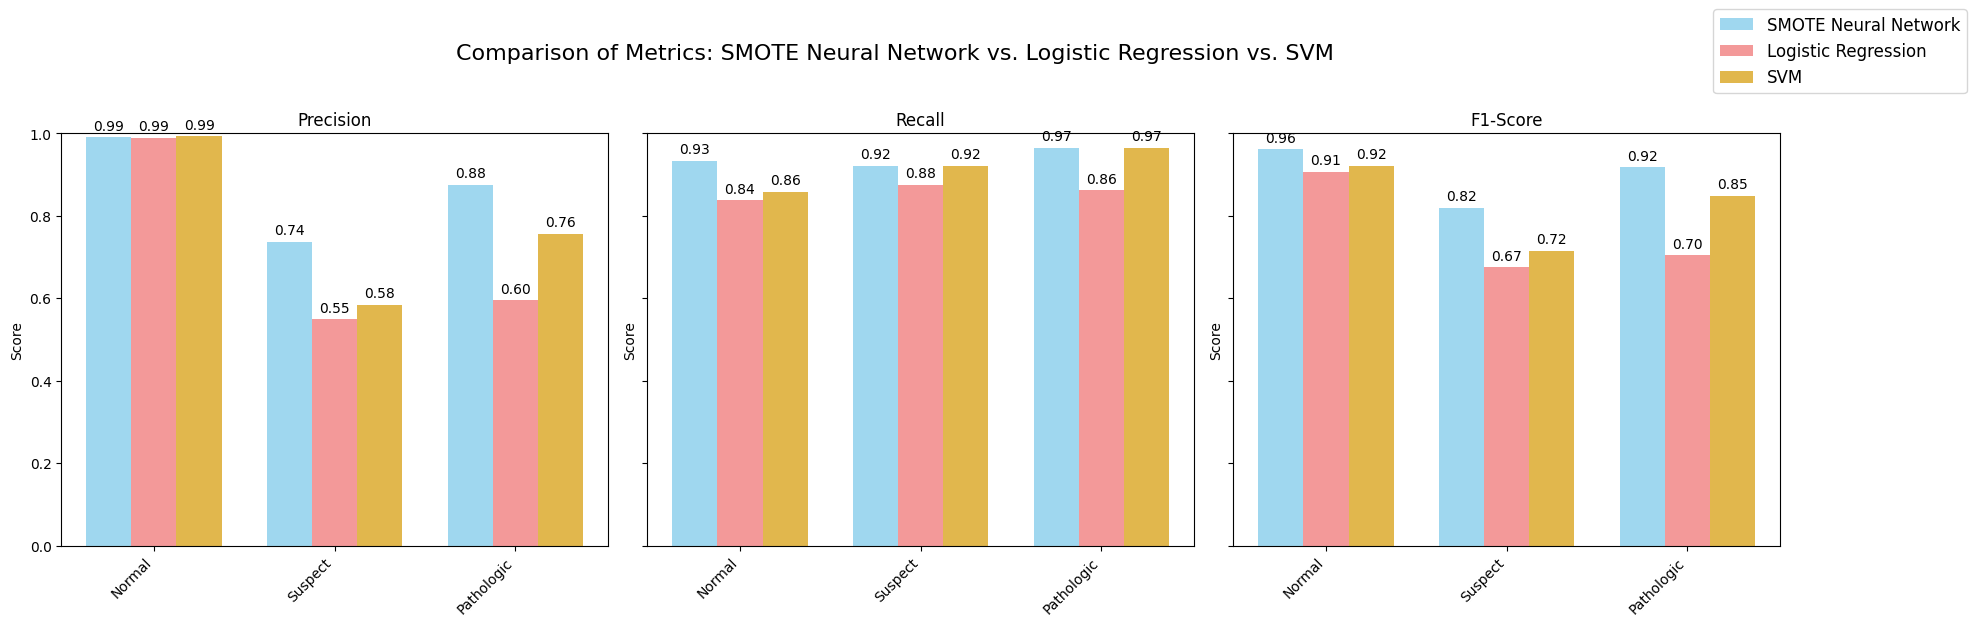


Model Comparison Summary:

SMOTE Neural Network Weighted Average Metrics:
Precision: 0.945
Recall: 0.934
F1-Score: 0.937
Accuracy: 0.934

Logistic Regression Weighted Average Metrics:
Precision: 0.896
Recall: 0.845
F1-Score: 0.859
Accuracy: 0.845

SVM Weighted Average Metrics:
Precision: 0.916
Recall: 0.876
F1-Score: 0.885
Accuracy: 0.876


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

def compare_trained_models(smote_model, lr_model, svm_model, X_test_scaled, y_test):
    """
    Compares a SMOTE-trained neural network model, a logistic regression model, and a support vector machine.
    Returns the comparison metrics and creates visualization plots, including Accuracy.
    """
    # Get predictions
    y_pred_smote_nn = smote_model.predict(X_test_scaled)
    y_pred_lr = lr_model.predict(X_test_scaled)
    y_pred_svm = svm_model.predict(X_test_scaled)

    # If the SMOTE-trained neural network outputs probabilities, convert them to class predictions
    if y_pred_smote_nn.ndim > 1:
        y_pred_smote_nn = np.argmax(y_pred_smote_nn, axis=1)

    # Calculate Accuracy
    accuracy_smote_nn = accuracy_score(y_test, y_pred_smote_nn)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)

    # Get classification reports
    report_smote_nn = classification_report(y_test, y_pred_smote_nn,
                                            target_names=["Normal", "Suspect", "Pathologic"],
                                            output_dict=True)
    report_lr = classification_report(y_test, y_pred_lr,
                                       target_names=["Normal", "Suspect", "Pathologic"],
                                       output_dict=True)
    report_svm = classification_report(y_test, y_pred_svm,
                                        target_names=["Normal", "Suspect", "Pathologic"],
                                        output_dict=True)

    # Create comparison DataFrame with consistent naming
    comparison_data = {
        'precision_SMOTE_NN': [report_smote_nn[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_SMOTE_NN': [report_smote_nn[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_SMOTE_NN': [report_smote_nn[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]],
        'precision_LogReg': [report_lr[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_LogReg': [report_lr[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_LogReg': [report_lr[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]],
        'precision_SVM': [report_svm[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_SVM': [report_svm[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_SVM': [report_svm[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]]
    }

    comparison_df = pd.DataFrame(comparison_data,
                                 index=["Normal", "Suspect", "Pathologic"])

    # Create visualization
    metrics = ["Precision", "Recall", "F1-Score"]
    classes = comparison_df.index
    x = np.arange(len(classes))
    width = 0.25

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, metric in enumerate(metrics):
        smote_nn_values = comparison_df[f'{metric.lower()}_SMOTE_NN']
        lr_values = comparison_df[f'{metric.lower()}_LogReg']
        svm_values = comparison_df[f'{metric.lower()}_SVM']

        ax = axes[i]
        rects1 = ax.bar(x - width, smote_nn_values, width, label='SMOTE Neural Network', color='skyblue', alpha=0.8)
        rects2 = ax.bar(x, lr_values, width, label='Logistic Regression', color='lightcoral', alpha=0.8)
        rects3 = ax.bar(x + width, svm_values, width, label='SVM', color='goldenrod', alpha=0.8)

        ax.set_title(metric)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)

        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width()/2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)
        autolabel(rects3)

    # Add a single legend for all plots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.05), fontsize=12)

    fig.suptitle("Comparison of Metrics: SMOTE Neural Network vs. Logistic Regression vs. SVM", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print summary statistics
    print("\nModel Comparison Summary:")
    print("\nSMOTE Neural Network Weighted Average Metrics:")
    print(f"Precision: {report_smote_nn['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_smote_nn['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_smote_nn['weighted avg']['f1-score']:.3f}")
    print(f"Accuracy: {accuracy_smote_nn:.3f}")

    print("\nLogistic Regression Weighted Average Metrics:")
    print(f"Precision: {report_lr['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_lr['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_lr['weighted avg']['f1-score']:.3f}")
    print(f"Accuracy: {accuracy_lr:.3f}")

    print("\nSVM Weighted Average Metrics:")
    print(f"Precision: {report_svm['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_svm['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_svm['weighted avg']['f1-score']:.3f}")
    print(f"Accuracy: {accuracy_svm:.3f}")

    return comparison_df


# Call the function with your models and test data
comparison_df = compare_trained_models(smote_model, lr_model, svm_model, X_test_scaled_selected, y_test)
